# Complex Reactions in PBR & CSTR & semi-BR & BR

In [2]:
# ALWAYS START WITH THIS CODE...SUGGEST NOT TO CHANGE IT
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.integrate
import scipy.optimize

## Assignment 6 Part 4
Now that the semi-BR works we can convert it to a BR.



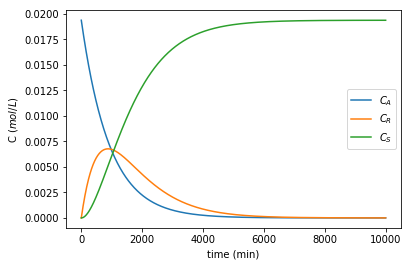

Comparing to Fogler

Ca: 0.000000
 Cr: 0.000002
 Cs: 0.019369


Maximum concentration is 0.00677 mol/dm3
It occurs at about 880.1 +/- 10.0 seconds


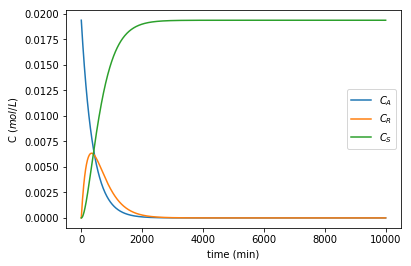

Comparing to Fogler

Ca: -0.000000
 Cr: -0.000000
 Cs: 0.019371


Maximum concentration is 0.00634 mol/dm3
It occurs at about 340.0 +/- 10.0 seconds


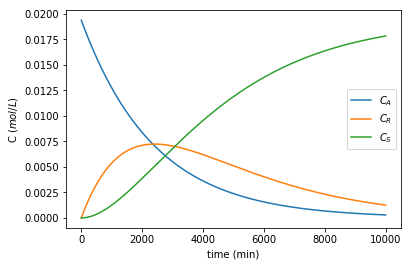

Comparing to Fogler

Ca: 0.000293
 Cr: 0.001253
 Cs: 0.017825


Maximum concentration is 0.00724 mol/dm3
It occurs at about 2410.2 +/- 10.0 seconds

For a CSTR with spacetime = 20.0 seconds
The concentration of A is 0.01896 M
The concentration of R is 0.0004001 M
The concentration of S is 9.521e-06 M


In [5]:
# These would be "initial conditions" for BR/semiBR, where time varies instead.
V0 = 2000 #L initial volume
P0 = 110 #kPa 8.314
Ca0 = P0 / (8.314 * 683) # M, initial concentration of A (only one in the reactor)

# Note only four species in this template...you'd need more or less depending on actual scenario.
# Ca0 = 0.375 # M, initial conc of A
Cr0 = 0 # M, initial concentration of R
Cs0 = 0 # M, init concentration of S

E1 = 42.6
E2 = 48.6
E3 = 32


# REALLY IMPORTANT!!!  First copy k's referenced to species.
# Then: Convert k's from species reference to reaction number reference by dividing by stoichiometric coefficient.
k1A = 0.00108 # L3/mol2/kgcat/min
k2R = 0.00119 # L5/mol4/kgcat/min
k3S = 0.00159

k1 = k1A/1
k2 = k2R/1
k3 = k3S/1


# NOTE:  adding this code just to illustrate use of exponential function np.exp and switching between reference and actual temp
Ea1 = 50 #kcal/mol
k1ref = k1
R_kcal = 0.00198720413 # kcal/mol/K
Tref = 410. + 273.15 #reference temperature in K--I've set this to be 410C like PS6Q4
T = 410 + 273.15 # actual temperature in K--for now, left it at 410C
k1_430 = k1ref * np.exp(-1*Ea1/R_kcal * (1./T - 1./Tref)) #Arrhenius computation of rate constant k1 at new temp

def ref_switch(k_val, E_val, Tref, T):
    Ea1 = 50 #kcal/mol
    R_kcal = 0.00198720413 # kcal/mol/K
    Tref = Tref + 273.15 #reference temperature in K--I've set this to be 410C like PS6Q4
    T = T + 273.15 # actual temperature in K--for now, left it at 410C
    k_new = k_val * np.exp(-1*E_val/R_kcal * (1./T - 1./Tref)) #Arrhenius computation of rate constant k1 at new temp
    return k_new

k1_430 = ref_switch(k1, E1, 410, 430)
k2_430 = ref_switch(k2, E2, 410, 430)
k3_430 = ref_switch(k3, E3, 410, 430)

k1_390 = ref_switch(k1, E1, 410, 390)
k2_390 = ref_switch(k2, E2, 410, 390)
k3_390 = ref_switch(k3, E3, 410, 390)

# The function block that follows defines all the differential equation forms.
def dCvectordt1(Cvector, time):
    """
    Differential equation for flows as a function of weight of catalyst
    """
    Ca, Cr, Cs = Cvector # unpack values from vector into four flows and the y variable for PFR

    # compute the rates of reactions
    r1 = k1 * Ca
    r2 = k2 * Cr
    r3 = k3 * Cs * Cr

    # compute the rates of generation of all species
    ra = -1 * r1 - 0 * r2
    rr = +1 * r1 - 1 * r3 - 1 * r2
    rs = +1 * r2 + 1 * r3
    
    # Express the differential equations for rates of change of flows....
    # note you'd have additional terms for semi-BR or membrane PFR representing in/out flows
    dCadt = ra
    dCrdt = rr
    dCsdt = rs

    return [dCadt, dCrdt, dCsdt] # pack up values into a vector.
    # "return" sends the info back to the ODE solver, many times
    
# The function block that follows defines all the differential equation forms.
def dCvectordt2(Cvector, time):
    """
    Differential equation for flows as a function of weight of catalyst
    """
    Ca, Cr, Cs = Cvector # unpack values from vector into four flows and the y variable for PFR

    # compute the rates of reactions
    r1 = k1_430 * Ca
    r2 = k2_430 * Cr
    r3 = k3_430 * Cs * Cr

    # compute the rates of generation of all species
    ra = -1 * r1 - 0 * r2
    rr = +1 * r1 - 1 * r3 - 1 * r2
    rs = +1 * r2 + 1 * r3
    
    # Express the differential equations for rates of change of flows....
    # note you'd have additional terms for semi-BR or membrane PFR representing in/out flows
    dCadt = ra
    dCrdt = rr
    dCsdt = rs

    return [dCadt, dCrdt, dCsdt] # pack up values into a vector.
    # "return" sends the info back to the ODE solver, many times

# The function block that follows defines all the differential equation forms.
def dCvectordt3(Cvector, time):
    """
    Differential equation for flows as a function of weight of catalyst
    """
    Ca, Cr, Cs = Cvector # unpack values from vector into four flows and the y variable for PFR

    # compute the rates of reactions
    r1 = k1_390 * Ca
    r2 = k2_390 * Cr
    r3 = k3_390 * Cs * Cr

    # compute the rates of generation of all species
    ra = -1 * r1 - 0 * r2
    rr = +1 * r1 - 1 * r3 - 1 * r2
    rs = +1 * r2 + 1 * r3
    
    # Express the differential equations for rates of change of flows....
    # note you'd have additional terms for semi-BR or membrane PFR representing in/out flows
    dCadt = ra
    dCrdt = rr
    dCsdt = rs

    return [dCadt, dCrdt, dCsdt] # pack up values into a vector.
    # "return" sends the info back to the ODE solver, many times

    
steps = np.linspace(0, 10001, num=1001) # steps for ODE integration.  Here W begins at 0 and goes to 1000, with "num" steps.

Cvector0 = [Ca0, Cr0, Cs0] # initial values as specified way up above

Y_result = scipy.integrate.odeint(dCvectordt1, Cvector0, steps) # BOOM!  the ODE integration happens here!
# Note:  errors from this statement generally due to some incompatibility, like the vectors not the same length.
Y_result_430 = scipy.integrate.odeint(dCvectordt2, Cvector0, steps) # New integration values based on
# new k value
Y_result_390 = scipy.integrate.odeint(dCvectordt3, Cvector0, steps) # New integration values based on
# extract columns by transposing matrix and splitting into variables (the template has 4 flows and "y")
Ca, Cr, Cs = Y_result.T
Ca_430, Cr_430, Cs_430 = Y_result_430.T # New Concentrations based on 430 C
Ca_390, Cr_390, Cs_390 = Y_result_390.T # New Concentrations based on 430 C

# Do some plotting.  the plt.plot commands make the plots
plt.plot(steps, Ca, label='$C_A$')
plt.plot(steps, Cr, label='$C_R$')
plt.plot(steps, Cs, label='$C_S$')
# the next three lines format the plots with legend and axis labels.
plt.legend(loc="best")
plt.xlabel('time (min)')
plt.ylabel('C ($mol/L$)')
plt.show()  # this displays the plot

print("Comparing to Fogler\n")
print("Ca: %f\n" % Ca[1000],"Cr: %f\n" % Cr[1000],"Cs: %f\n" % Cs[1000]) #checking versus Fogler
print("")
# this is just some code to locate a maximum and print some info
# first define the function for any array we call concentrations
# so that we can re-use it later
def report_maxC(concentrations, timesteps):
    max_R = concentrations.max()
    print ("Maximum concentration is {0:.3g} mol/dm3".format(max_R))
    index = concentrations.argmax()
    max_time = timesteps[index]
    stepsize = timesteps[1]
    print ("It occurs at about {0:.1f} +/- {1:.1f} seconds".format(
                                                        max_time, stepsize))
# now call the function on the current Cc array
report_maxC(Cr, steps)  # for now we won't call that function!

# ***** New temp graph
# Do some plotting.  the plt.plot commands make the plots
plt.plot(steps, Ca_430, label='$C_A$')
plt.plot(steps, Cr_430, label='$C_R$')
plt.plot(steps, Cs_430, label='$C_S$')
# the next three lines format the plots with legend and axis labels.
plt.legend(loc="best")
plt.xlabel('time (min)')
plt.ylabel('C ($mol/L$)')
plt.show()  # this displays the plot
print("Comparing to Fogler\n")
print("Ca: %f\n" % Ca_430[1000],"Cr: %f\n" % Cr_430[1000],"Cs: %f\n" % Cs_430[1000]) #checking versus Fogler
print("")

report_maxC(Cr_430, steps)

# ***** New temp graph
# Do some plotting.  the plt.plot commands make the plots
plt.plot(steps, Ca_390, label='$C_A$')
plt.plot(steps, Cr_390, label='$C_R$')
plt.plot(steps, Cs_390, label='$C_S$')
# the next three lines format the plots with legend and axis labels.
plt.legend(loc="best")
plt.xlabel('time (min)')
plt.ylabel('C ($mol/L$)')
plt.show()  # this displays the plot
print("Comparing to Fogler\n")
print("Ca: %f\n" % Ca_390[1000],"Cr: %f\n" % Cr_390[1000],"Cs: %f\n" % Cs_390[1000]) #checking versus Fogler
print("")

report_maxC(Cr_390, steps)
# END OF PART 2

V = 2500 # L
v0 = 100 # L/min
tau = 1200 / 60 # s * min/s
    
def dNvectordt(Cvector):
    """
    This is a differential equation for the number of moles
    of each species in the reactor, as function of time.
    At steady state it should equal zero.
    We must pass in the exit species concentrations in a vector.
    """
    Ca, Cr, Cs = Cvector 
     # compute the rates of reactions
    r1 = k1 * Ca
    r2 = k2 * Cr
    r3 = k3 * Cs * Cr

    # compute the rates of generation of all species
    ra = -1 * r1 - 0 * r2
    rr = +1 * r1 - 1 * r3 - 1 * r2
    rs = +1 * r2 + 1 * r3

    # Differential equations for rates of change of moles
    dNadt = v0 * ( Ca0 - Ca + ra * tau)
    dNbdt = v0 * ( Cr0 - Cr + rr * tau)
    dNcdt = v0 * ( Cs0 - Cs + rs * tau)
    return [dNadt, dNbdt, dNcdt]

guess = [Ca0/2, Ca0/2, Ca0/2] # initial guess
result = scipy.optimize.root(dNvectordt, guess)

Ca, Cr, Cs = result.x

print ("")
print ("For a CSTR with spacetime = {0} seconds".format(tau))
for (label, value) in [('A',Ca),('R', Cr),('S',Cs)]:
    print ("The concentration of {0} is {1:.4} M".format(label,value))